First, we inspect the data and check for missing values.

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv('train.csv', index_col='PassengerId')
print(df.head(5))

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


We see that there are a number of columns with values that are not numeric, so we must do some feature engneering. We start with the 'Name' column and extract the titles, which are the only relevent parts of this feature. 

In [9]:
#Get rid of punctuation
df_clean = df.copy()
df_clean['Name'] = df_clean['Name'].str.replace('[^a-zA-Z]', ' ',regex=True).str.lower()

#Find the different titles
dup_titles = []
for name in df_clean['Name'].values:
    dup_titles.append(name.split('  ')[1])

#Add a new feature 'Titled' to replace names
df_clean['Title']=df_clean['Name'].map(lambda x: x.split('  ')[1])
print(df_clean['Title'].value_counts())

#Keep miss, mrs, mr, special title, master
def replace_titles(x):
    title=x['Title']
    if title in ['ms', 'mlle']:
        return 'miss'
    elif title=='mme':
        return 'mrs'
    elif title=='don':
        return 'mr'
    elif title in ['major', 'capt', 'jonkheer', 'rev', 'col', 'the countess', 'lady', 'sir', 'dr']:
        return 'titled'
    else:
        return title
    
df_clean['Title']=df_clean.apply(replace_titles, axis=1)
print(df_clean['Title'].value_counts())

mr              517
miss            182
mrs             125
master           40
dr                7
rev               6
mlle              2
major             2
col               2
the countess      1
capt              1
ms                1
sir               1
lady              1
mme               1
don               1
jonkheer          1
Name: Title, dtype: int64
mr        518
miss      185
mrs       126
master     40
titled     22
Name: Title, dtype: int64


Moving on to the 'Fare' feature, we notice that some values were 0, so we replace those with the median (since the data is skewed).

In [10]:
print(df_clean['Fare'].mean())
print(df_clean['Fare'].median())
#We use the median because the data is skewed
df_clean.loc[df_clean['Fare']==0,'Fare'] = df_clean.loc[df_clean['Fare']!=0,'Fare'].median()

32.204207968574636
14.4542


We drop the 'Name' and 'Ticket' features, and add two new features that may be helpful.

In [11]:
df_clean.drop(['Name','Ticket'],axis=1,inplace=True)
df_clean['Family_Size'] = df_clean['SibSp'] + df_clean['Parch']
df_clean['Fare_Per_Person']=df_clean['Fare']/(df_clean['Family_Size']+1)

We extract the decks from the cabin, and since only first class gets a cabin, we input 'None' for the rest of the classes. 

In [12]:
df_clean['Cabin'] = df_clean['Cabin'][df_clean['Cabin'].notnull()].str.extract('([A-Z])')
df_clean['Cabin'].fillna(value='None', inplace=True)

print(df_clean['Cabin'].value_counts())

None    687
C        59
B        47
D        33
E        32
A        15
F        13
G         4
T         1
Name: Cabin, dtype: int64


We use sckit-learn's SimpleImputer to fill the missing categorical feature values with the most frequent value, and fill the missing numerical feature values with the mean.

In [13]:
from sklearn.impute import SimpleImputer

imp_cat = SimpleImputer(strategy="most_frequent")
df_clean['Embarked'] = imp_cat.fit_transform(df_clean[['Embarked']])
#X_test_emb = imp_cat.transform(X_test_cat)

#MEAN OR MEDIAN?
imp_num = SimpleImputer()
df_clean['Age']=imp_num.fit_transform(df_clean[['Age']])
#X_test_num = imp_num.transform(X_test_num)

We now create dummy variables for the categorical features.

In [14]:
df_clean = pd.get_dummies(df_clean, columns=['Sex','Cabin','Embarked','Title'], drop_first=True)
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Age              891 non-null    float64
 3   SibSp            891 non-null    int64  
 4   Parch            891 non-null    int64  
 5   Fare             891 non-null    float64
 6   Family_Size      891 non-null    int64  
 7   Fare_Per_Person  891 non-null    float64
 8   Sex_male         891 non-null    uint8  
 9   Cabin_B          891 non-null    uint8  
 10  Cabin_C          891 non-null    uint8  
 11  Cabin_D          891 non-null    uint8  
 12  Cabin_E          891 non-null    uint8  
 13  Cabin_F          891 non-null    uint8  
 14  Cabin_G          891 non-null    uint8  
 15  Cabin_None       891 non-null    uint8  
 16  Cabin_T          891 non-null    uint8  
 17  Embarked_Q      

In [15]:
df_clean.to_csv("clean_training_data.csv")

We now look at the distributions of the numerical features. 

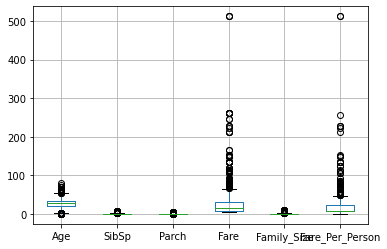

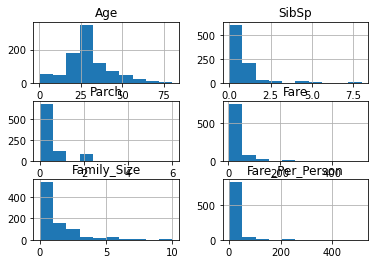

Age                0.434488
SibSp              3.695352
Parch              2.749117
Fare               4.812235
Family_Size        2.727441
Fare_Per_Person    7.804952
dtype: float64


In [16]:
dist = df_clean[['Age','SibSp','Parch','Fare','Family_Size','Fare_Per_Person']]
dist.boxplot()
dist.hist()
plt.show()
print(dist.skew())

As they are quite heavily skewed, we implement a log transformation using scikit-learn's PowerTransformer, which significantly reduces the skewness. 

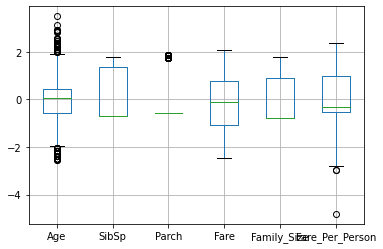

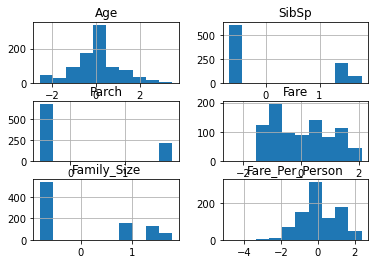

Age                0.064420
SibSp              0.808608
Parch              1.228795
Fare               0.233409
Family_Size        0.539231
Fare_Per_Person    0.071946
dtype: float64
        Age     SibSp     Parch      Fare  Family_Size  Fare_Per_Person
1 -0.556267  1.373636 -0.560253 -1.236388     0.893828        -2.002017
2  0.657269  1.373636 -0.560253  1.394717     0.893828         1.329152
3 -0.241577 -0.679850 -0.560253 -1.071273    -0.796169        -0.464334
4  0.437923  1.373636 -0.560253  1.205801     0.893828         1.080442
5  0.437923 -0.679850 -0.560253 -1.042860    -0.796169        -0.438036


In [17]:
from sklearn.preprocessing import PowerTransformer

log = PowerTransformer()
scaled_dist = pd.DataFrame(log.fit_transform(dist),columns=['Age','SibSp','Parch','Fare','Family_Size','Fare_Per_Person'],index=np.arange(1,len(df_clean)+1))
scaled_dist.boxplot()
scaled_dist.hist()
plt.show()
print(scaled_dist.skew())
print(scaled_dist.head())

This is what the data looks like now:

In [18]:
ABC = ['Age','SibSp','Parch','Fare','Family_Size','Fare_Per_Person']
for a in ABC:
    df_clean[a] = scaled_dist[a]
print(df_clean.head())
df_clean.to_csv("scaled_training_data.csv")

             Survived  Pclass       Age     SibSp     Parch      Fare  \
PassengerId                                                             
1                   0       3 -0.556267  1.373636 -0.560253 -1.236388   
2                   1       1  0.657269  1.373636 -0.560253  1.394717   
3                   1       3 -0.241577 -0.679850 -0.560253 -1.071273   
4                   1       1  0.437923  1.373636 -0.560253  1.205801   
5                   0       3  0.437923 -0.679850 -0.560253 -1.042860   

             Family_Size  Fare_Per_Person  Sex_male  Cabin_B  ...  Cabin_F  \
PassengerId                                                   ...            
1               0.893828        -2.002017         1        0  ...        0   
2               0.893828         1.329152         0        0  ...        0   
3              -0.796169        -0.464334         0        0  ...        0   
4               0.893828         1.080442         0        0  ...        0   
5              -0.79

Our data pre-processing is complete! We can now move on to model selection and evaluation!